<a href="https://colab.research.google.com/github/nv-hiep/dust_grain_fit/blob/main/run_dustfit_WD2001_pymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dust Grain Fit using pymc3 (MW)**

# 1. Mount the google drive

In [26]:
from google.colab import drive
drive.mount('/content/gdrive')
# !ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
!pip3 install uncertainties

In [28]:
!pip3 install emcee

In [29]:
!pip3 install corner

# 2. Root directory

In [30]:
cd '/content/gdrive/My Drive/Colab Notebooks/dustfit'

/content/gdrive/My Drive/Colab Notebooks/dustfit


# 3. Import Libraries



In [31]:
#!/usr/bin/env python
from __future__ import print_function

import os
import sys
import time

import numpy             as np
import matplotlib.pyplot as pyplot

import matplotlib
from matplotlib.ticker import ScalarFormatter

import pymc3   as pm

import theano
import theano.tensor as tt

import pandas as pd
# import pymc3 as pm
# from pymc3.backends.base import MultiTrace
# import theano.tensor as tt
import uncertainties.unumpy as unp

import emcee
import corner

from astropy.io     import fits

from libs.dustmodel import DustModel, MRN77, WD01
from libs.dustdata  import DustData

## 4. Data

In [32]:
# Path to the data
root_path = os.getcwd()
print(os.getcwd())
print(os.path.dirname(os.path.realpath('__file__')))

/content/gdrive/My Drive/Colab Notebooks/dustfit
/content/gdrive/My Drive/Colab Notebooks/dustfit


In [33]:
# Pymc3 params for the fit
sel_step     = 5
sizedisttype = 'WD'
gal          = 'MW'

# set the prefix_filename of the output
prefile = os.path.join(root_path, 'results', sizedisttype) # eg: path.. results/test_MRN

print('The prefix_filename of the output file: ', prefile)


# Path to data
path = os.path.join(root_path, 'data', gal)

The prefix_filename of the output file:  /content/gdrive/My Drive/Colab Notebooks/dustfit/results/WD


In [34]:
# Read observed data 
obsdata = DustData(path,
                    abundance  = True,
                    extinction = True,
                    emission   = True,
                    scattering = True,
                    ISRF       = True,
                    ext_tags   = ['band', 'iue', 'fuse'] )

In [35]:
def get_arr_obsdata(obsdata):
    
    # extinction
    yobs      = obsdata.ext_AlNHI
    yerr      = obsdata.ext_AlNHI_err

    # Abundances
    atomabund_y    = []
    atomabund_yerr = []
    for atomname, atomval in obsdata.abundance.items():
        atomabund_y.append( obsdata.abundance[atomname][0] )
        atomabund_yerr.append( obsdata.abundance[atomname][1] )

    atomabund_y    = np.array(atomabund_y)
    atomabund_yerr = np.array(atomabund_yerr)

    yobs           = np.concatenate( [yobs, atomabund_y] )
    yerr           = np.concatenate( [yerr, atomabund_yerr] )

    # Emission
    yobs           = np.concatenate( [yobs, obsdata.spec_] )
    yerr           = np.concatenate( [yerr, obsdata.spec_err] )

    # Albedo
    yobs           = np.concatenate( [yobs, obsdata.scat_albedo] )
    yerr           = np.concatenate( [yerr, obsdata.scat_albedo_err] )

    # g=cos(theta)
    yobs           = np.concatenate( [yobs, obsdata.scat_g] )
    yerr           = np.concatenate( [yerr, obsdata.scat_g_err] )

    return (yobs, yerr)

In [36]:
# Grain components
grain_types = ['silicates','carbonaceous']


# # min and max grain radii for MRN distribution
# AMIN     = 0.005   # micron
# AMAX     = 0.3     # micron
if sizedisttype == 'MRN':
    
    # define the fitting model
    dustmodel = MRN77(componentnames=grain_types, path=root_path, from_obs=True, sel_step=sel_step)

    p0 = []
    pnames = []
    for k, component in enumerate(dustmodel.components):
        cparams = dustmodel.parameters[component.name]
        p0     += [cparams['C'], cparams['p'], cparams['amin'], cparams['amax']]
        pnames += [ 'C'+str(k), 'p'+str(k), 'amin'+str(k), 'amax'+str(k) ]

    # need to set dust model size distribution
    # sizedist = A*a^-alpha, A = params['C'] : Amplitude
    dustmodel.set_size_dist(p0)




elif sizedisttype == 'WD':

    dustmodel = WD01(componentnames=grain_types, path=root_path, from_obs=True, sel_step=sel_step)

    # initial guesses at parameters
    p0     = []
    pnames = []
    for k, component in enumerate(dustmodel.components):
        if component.name == 'silicates':
            cparams  = dustmodel.parameters['silicates']
            p0      += [ cparams['C_s'], cparams['a_ts'], cparams['alpha_s'], cparams['beta_s'] ]
            pnames  += ['C_s'+str(k), 'a_ts'+str(k), 'alpha_s'+str(k), 'beta_s'+str(k)]
        else:
            cparams  = dustmodel.parameters['carbonaceous']
            p0      += [cparams['C_g'], cparams['a_tg'], cparams['alpha_g'], cparams['beta_g'], cparams['a_cg'],cparams['b_C'] ]
            pnames  += [ 'C_g'+str(k), 'a_tg'+str(k), 'alpha_g'+str(k), 'beta_g'+str(k), 'a_cg'+str(k), 'b_C'+str(k)]

    # need to set dust model size distribution
    dustmodel.set_size_dist(p0)

else:
    print('Please select a size distribution [MRN, WD]')
    exit()
# End - if

In [37]:
# Initial values of paramters, and number of parameters
print('p0: ', p0)
print('param names: ', pnames)
npars = len(p0)
print('Number of params: ', npars)



for k, component in enumerate(dustmodel.components):
    print('Component: ', component)
    print( 'Size distribution:', component.size_dist )
    print( 'Length of size distribution:', len(component.size_dist) )
    print()


# Get the observed data as arrays of yobs and yerr
(yobs, yerr) = get_arr_obsdata(obsdata)

p0:  [1.33e-12, 1710.0, -1.41, -11.5, 4.15e-11, 83.7, -1.91, -0.125, 4990.0, 3e-05]
param names:  ['C_s0', 'a_ts0', 'alpha_s0', 'beta_s0', 'C_g1', 'a_tg1', 'alpha_g1', 'beta_g1', 'a_cg1', 'b_C1']
Number of params:  10
Component:  <libs.dustgrains.DustGrains object at 0x7f5366281940>
Size distribution: [2.21860096e-001 6.19342902e-002 1.71113015e-002 4.65016120e-003
 1.23193322e-003 3.14428905e-004 7.62960948e-005 1.73994710e-005
 3.70895674e-006 7.41310305e-007 1.40345176e-007 2.55020678e-008
 4.47977311e-009 3.29404998e-011 9.69798496e-032 1.18395474e-182
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000]
Length of size distribution: 25

Component:  <libs.dustgrains.DustGrains object at 0x7f53711a1b00>
Size distribution: [1.77076904e+001 4.25384157e+000 2.03992342e-001 7.01460520e-003
 2.05964387e-003 5.14115344e-004 6.23822129e-005 9.74766913e-006
 1.87722195e-006 3.48139497e-007 6.055514

In [38]:
@theano.compile.ops.as_op(itypes=[tt.dscalar]*npars, otypes=[tt.dvector])
def model_fcn(*args):
    '''
    | Spectral energy distribution of a galaxy as a modified black body in units of mJy
    |
    | Flux_nu = (M_dust / d^2) * kappa_nu0 * (nu/nu0)^beta * Planck function
    |
    | Note: M_dust in the form of 10^{M}*Msun
    |
    | --Params:
    |           nu_obs: 1-D array - the observed frequency of flux measurements
    |           T:      ndarray/array/scalar - dust temperature
    |           beta:   1-D array - the emissivity parameter
    |           M   :   1-D array - the mass of dust in the galaxy in the form of  Msun * 10^M
    |           d:      1-D array - the distance to the galaxy
    |           z:      1-D array - the redshift of the galaxy
    |
    | --Return:
    |            spectral energy distribution of a galaxy as a modified black body in units of mJy
    '''

    # p_pars = [float(C0), float(p0), float(amin0), float(amax0), float(C1), float(p1), float(amin1), float(amax1)]
    p_pars = [float(x) for x in args]

    # Update size_dist, self.component.size_dist (25,)
    dustmodel.set_size_dist(p_pars)


    # Values from model
    model_values = dustmodel.eff_grain_props(obsdata)

    model_fit = []

    # extinction
    model_fit = 1.086 * (model_values['cabs'] + model_values['csca'])

    # Abundances
    natoms         = model_values['natoms']
    atomabund_mod  = []
    for atomname, atomval in natoms.items():
        atomabund_mod.append( atomval )

    model_fit = np.concatenate( [model_fit, np.array(atomabund_mod)] )

    # emission
    model_fit = np.concatenate( [model_fit, model_values['emission']] )

    # albedo
    model_fit = np.concatenate( [model_fit, model_values['albedo']] )

    # g=cos(theta)
    model_fit = np.concatenate( [model_fit, model_values['g']] )

    return model_fit

In [39]:
# Setup the pm3 model
with pm.Model() as model:

    # Priors
    prior_pars = {}
    for name, val  in zip( pnames, p0 ):
        # prior_pars[name] = pm.Uniform(name, lower=ps, upper=pf) # uniform prior
        prior_pars[name] = pm.Normal(name, mu=val, sd=0.05*val)


    # Expected value of outcome, a.k.a  the model
    # mu = model_fcn(prior_pars)
    mu = model_fcn(*[ prior_pars[name] for name in pnames])

    # Likelihood (sampling distribution) of observations
    _ = pm.Normal('Y_obs', mu=mu, sd=yerr, observed=yobs)
# end - with



'''
 Setup the pm3 params for the fit
 n_sample : number of samples to take
 chains   : number of concurrent chains
 burn     : number of initial samples to burn
 thin     : multiple of samples to keep
'''
n_sample = 10000
n_sample = 1000

tune     = 2000
tune     = 100

chains   = 3
burn     = int(0.1*n_sample)
thin     = 5


#>>>> Run the fit
with model:
    #start = pm.find_MAP()
    #step =pm.NUTS()    
    # start = {'C0': 1e-25, 'p0': 3.5, 'amin0': 1e-07, 'amax0': 0.001, 'C1': 1e-25, 'p1': 3.5, 'amin1': 1e-07, 'amax1': 0.001}
    start = {}
    for k,v in zip(pnames, p0) :
        start[k] = v
    step = pm.Metropolis()

with model:
    trace = pm.sample(n_sample, step, start, chains=chains, tune=tune)
#<<<<    

Sequential sampling (3 chains in 1 job)
CompoundStep
>Metropolis: [b_C1]
>Metropolis: [a_cg1]
>Metropolis: [beta_g1]
>Metropolis: [alpha_g1]
>Metropolis: [a_tg1]
>Metropolis: [C_g1]
>Metropolis: [beta_s0]
>Metropolis: [alpha_s0]
>Metropolis: [a_ts0]
>Metropolis: [C_s0]
100%|██████████| 1100/1100 [13:12<00:00,  1.39it/s]


In [40]:

# Save the best fit params
fit_params_best = []
dat             = {}
for par in pnames:
    values = trace.get_values(par, burn=burn, thin=thin)
    fit_params_best.append(values.mean(axis=0))

    dat[par+'_mean'] = [values.mean(axis=0)]
    dat[par+'_std']  = [values.std(axis=0)]


# Mean and std of the params
print('Mean and std of the params: ')
print(dat)

# Save the params to csv
df = pd.DataFrame(data=dat)
print( df.head() )
df.to_csv(index=False)

# The number of effective samples is smaller than 25% for some parameters.
# {'C0_mean': [9.001064750768227e-26], 'C0_std': [1.0916226096423437e-29], 'p0_mean': [3.150029649240011], 'p0_std': [3.0970264831119365e-05], 'amin0_mean': [9.969435022428174e-08], 'amin0_std': [6.0505440466563e-09], 'amax0_mean': [0.0009970073309611227], 'amax0_std': [5.6855812599731864e-05], 'C1_mean': [9.000059096040242e-26], 'C1_std': [5.415110422299333e-31], 'p1_mean': [3.1500012158405823], 'p1_std': [1.1912495223190136e-06], 'amin1_mean': [9.98342610582984e-08], 'amin1_std': [5.756200710757336e-09], 'amax1_mean': [0.0009923324663932533], 'amax1_std': [5.6590062787141085e-05]}
#         C0_mean        C0_std  p0_mean  ...     amin1_std  amax1_mean  amax1_std
# 0  9.001065e-26  1.091623e-29  3.15003  ...  5.756201e-09    0.000992   0.000057

# [1 rows x 16 columns]


# {'C0_mean': [1.0000000000000002e-25], 'C0_std': [1.1479437019748901e-41], 'p0_mean': [3.145885655438738], 'p0_std': [0.003178120488211224], 'amin0_mean': [1e-07], 'amin0_std': [0.0], 'amax0_mean': [0.0010000000000000002], 'amax0_std': [2.168404344971009e-19], 'C1_mean': [1.0000000000000002e-25], 'C1_std': [1.1479437019748901e-41], 'p1_mean': [2.752089836517056], 'p1_std': [0.005391810678624622], 'amin1_mean': [1e-07], 'amin1_std': [0.0], 'amax1_mean': [0.0010000000000000002], 'amax1_std': [2.168404344971009e-19]}

Mean and std of the params: 
{'C_s0_mean': [1.3300000000000002e-12], 'C_s0_std': [2.0194839173657902e-28], 'a_ts0_mean': [1710.0], 'a_ts0_std': [0.0], 'alpha_s0_mean': [-1.41], 'alpha_s0_std': [0.0], 'beta_s0_mean': [-11.5], 'beta_s0_std': [0.0], 'C_g1_mean': [4.1500000000000005e-11], 'C_g1_std': [6.462348535570529e-27], 'a_tg1_mean': [83.7], 'a_tg1_std': [0.0], 'alpha_g1_mean': [-1.9100000000000001], 'alpha_g1_std': [2.220446049250313e-16], 'beta_g1_mean': [-0.125], 'beta_g1_std': [0.0], 'a_cg1_mean': [4990.0], 'a_cg1_std': [0.0], 'b_C1_mean': [3.0000000000000004e-05], 'b_C1_std': [3.3881317890172014e-21]}
      C_s0_mean      C_s0_std  a_ts0_mean  ...  a_cg1_std  b_C1_mean      b_C1_std
0  1.330000e-12  2.019484e-28      1710.0  ...        0.0    0.00003  3.388132e-21

[1 rows x 20 columns]


'C_s0_mean,C_s0_std,a_ts0_mean,a_ts0_std,alpha_s0_mean,alpha_s0_std,beta_s0_mean,beta_s0_std,C_g1_mean,C_g1_std,a_tg1_mean,a_tg1_std,alpha_g1_mean,alpha_g1_std,beta_g1_mean,beta_g1_std,a_cg1_mean,a_cg1_std,b_C1_mean,b_C1_std\n1.3300000000000002e-12,2.0194839173657902e-28,1710.0,0.0,-1.41,0.0,-11.5,0.0,4.1500000000000005e-11,6.462348535570529e-27,83.7,0.0,-1.9100000000000001,2.220446049250313e-16,-0.125,0.0,4990.0,0.0,3.0000000000000004e-05,3.3881317890172014e-21\n'

In [44]:
# Save to FITS
fitsfile = prefile +'_pymc3_' + str(n_sample) + '_' + str(burn) + '.fits'
dustmodel.save_best_results_pm3(fitsfile, fit_params_best, obsdata)

In [47]:
def get_krange(x, logaxis=False, in_range=[0]):

    prange = np.array([0.0, 0.0])
    if logaxis:
        gindxs = x > 0
        min_x = np.amin(x[gindxs])
        max_x = np.amax(x[gindxs])
    else:
        min_x = np.amin(x)
        max_x = np.amax(x)

    if logaxis:
        max_x = np.log10(max_x)
        if min_x <= 0.0:
            min_x = max_x - 10.0
        else:
            min_x = np.log10(min_x)

    delta = max_x - min_x
    prange[0] = min_x - 0.1 * delta
    prange[1] = max_x + 0.1 * delta

    if logaxis:
        prange = np.power(10.0, prange)

    if len(in_range) > 1:
        prange[0] = np.minimum(prange[0], in_range[0])
        prange[1] = np.maximum(prange[1], in_range[1])

    return prange


# plot the size distributions
def plot_dgfit_sizedist(
    ax,
    hdulist,
    colors=["b", "g"],
    fontsize=12,
    multa4=True,
    plegend=True,
    ltype="-",
    alpha=1.0,
):

    if "DISTPUNC" in hdulist[1].data.names:
        plot_uncs = True
    else:
        plot_uncs = False

    yrange = [0]
    for i in range(hdulist[0].header["NCOMPS"]):
        hdu = hdulist[i + 1]

        xvals = hdu.data["SIZE"] * 1e4
        yvals = hdu.data["DIST"]

        if plot_uncs:
            yvals_punc = hdu.data["DISTPUNC"]
            yvals_munc = hdu.data["DISTMUNC"]

        if multa4:
            xvals4 = hdu.data["SIZE"] ** 4
            yvals = yvals * xvals4
            if plot_uncs:
                yvals_punc = yvals_punc * xvals4
                yvals_munc = yvals_munc * xvals4

        yrange = get_krange(yvals, logaxis=True, in_range=yrange)
        if plot_uncs:
            yrange = get_krange(yvals - yvals_munc, logaxis=True, in_range=yrange)
            yrange = get_krange(yvals + yvals_punc, logaxis=True, in_range=yrange)

        gindxs = yvals > 0

        ax.plot(
            xvals[gindxs],
            yvals[gindxs],
            colors[i] + ltype,
            label=hdu.header["EXTNAME"],
            alpha=alpha,
        )
        if plot_uncs:
            ax.errorbar(
                xvals[gindxs],
                yvals[gindxs],
                fmt=colors[i] + "o",
                yerr=[yvals_munc[gindxs], yvals_punc[gindxs]],
                alpha=alpha,
            )

    if multa4:
        ylabel = r"$a^4 N_d(a)/N(H)$"
    else:
        ylabel = r"$N_d(a)/N(H)$"

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(get_krange(xvals, logaxis=True))
    ax.set_ylim(yrange)
    ax.set_xlabel(r"$a [\mu m]$", fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    if plegend:
        ax.legend()


# plot the atomic abundances
def plot_dgfit_abundances(ax, hdu, obsdata, colors=["r", "b", "g"], fontsize=12):

    # plot the dust abundances
    atomnames = hdu.data["NAME"]
    atomabund = hdu.data["ABUND"]
    n_atoms   = len(atomnames)
    aindxs    = np.arange(n_atoms)
    width     = 0.5
    ax.bar(aindxs + 0.75 * width, atomabund, width)

    ax.errorbar(aindxs + 0.75 * width, [obsdata.abundance[x][0] for x in atomnames],
                yerr=[obsdata.abundance[x][1] for x in atomnames],
                fmt='ko', label='Observed')

    ax.set_ylabel(r"$N(X)/[10^6 N(H)]$", fontsize=fontsize)
    ax.set_xticks(aindxs + (0.75 * width))
    ax.set_xticklabels(atomnames)


# plot the extinction curves (total and components)
def plot_dgfit_extinction(ax, hdu, obsdata, colors=['r', 'b', 'g'], fontsize=12, comps=True, ltype="-"):

    ax.plot(1./hdu.data["WAVE"], hdu.data["EXT"], colors[0] + ltype, label='Total')
    yrange = get_krange(hdu.data["EXT"], logaxis=True)
    
    if comps:
        for i in range(len(hdu.data.names) - 2):
            ax.plot(1./hdu.data["WAVE"], hdu.data["EXT" + str(i + 1)], colors[i + 1] + ltype)
            yrange = get_krange(hdu.data["EXT" + str(i + 1)], logaxis=True, in_range=yrange)

    ax.plot(1./obsdata.ext_lambda, obsdata.ext_AlNHI, "k-", label="Observed")
    yrange = get_krange(obsdata.ext_AlNHI, logaxis=True, in_range=yrange)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$\lambda [\mu m]$", fontsize=fontsize)
    ax.set_ylabel(r"$A(\lambda)/N(H)$", fontsize=fontsize)

    ax.set_xlim(get_krange(1./hdu.data["WAVE"], logaxis=True))
    ax.set_ylim(yrange)
    ax.legend()


# plot the emission spectra (total and components)
def plot_dgfit_emission(ax, hdu, obsdata, colors=["r", "b", "g"], fontsize=12, comps=True, ltype="-"):
    ax.plot(hdu.data["WAVE"], hdu.data["EMIS"], colors[0] + ltype)
    yrange = get_krange(hdu.data["EMIS"], logaxis=True)
    if comps:
        # linetypes = ["-", "-", "-", "-", "-"]
        for i in range(len(hdu.data.names) - 2):
            ax.plot(
                hdu.data["WAVE"], hdu.data["EMIS" + str(i + 1)], colors[i + 1] + ltype,
            )
            yrange = get_krange(
                hdu.data["EMIS" + str(i + 1)], logaxis=True, in_range=yrange
            )

    ax.errorbar(
        obsdata.emis_lambda,
        obsdata.spec_,
        yerr=obsdata.spec_err,
        fmt="ko",
        label="Observed",
    )
    yrange = get_krange(obsdata.spec_, logaxis=True, in_range=yrange)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$\lambda [\mu m]$", fontsize=fontsize)
    ax.set_ylabel(r"$S$ $[MJy$ $sr^{-1}$ $N(H)^{-1}]$", fontsize=fontsize)

    ax.set_xlim(get_krange(hdu.data["WAVE"], logaxis=True))
    ax.set_ylim(yrange)


# plot the dust scattering albedo
def plot_dgfit_albedo(ax, hdu, obsdata, colors=["r", "b", "g"], fontsize=12, comps=True, ltype="-"):

    ax.plot(hdu.data["WAVE"], hdu.data["ALBEDO"], colors[0] + ltype)
    yrange = get_krange(hdu.data["ALBEDO"])
    if comps:
        for i in range(len(hdu.data.names) - 2):
            ax.plot(
                hdu.data["WAVE"],
                hdu.data["ALBEDO" + str(i + 1)],
                colors[i + 1] + ltype,
            )
            yrange = get_krange(hdu.data["ALBEDO" + str(i + 1)], in_range=yrange)

    ax.errorbar(
        obsdata.scat_albedo_lambda,
        obsdata.scat_albedo,
        yerr=obsdata.scat_albedo_err,
        fmt="ko",
        label="Observed",
    )
    # yrange = get_krange(obsdata.scat_albedo, in_range=yrange)

    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda [\mu m]$", fontsize=fontsize)
    ax.set_ylabel(r"$albedo$", fontsize=fontsize)

    ax.set_xlim(get_krange(hdu.data["WAVE"], logaxis=True))
    ax.set_ylim([0.0, 1.0])
    # ax.set_ylim(yrange)

/content/gdrive/My Drive/Colab Notebooks/dustfit/results/WD_pymc3_1000_100.fits


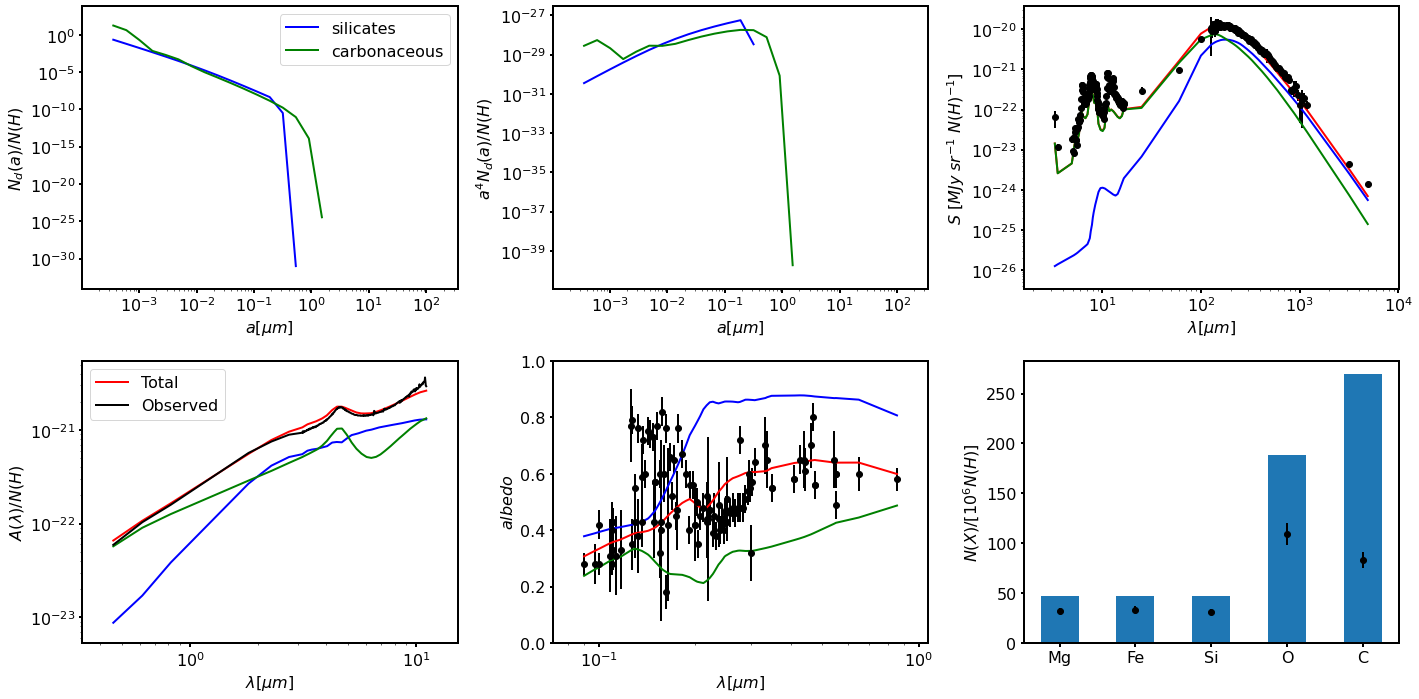

In [48]:
# fitsfile = 'dgfit_test_pm3_WD.fits'
# fitsfile = 'dgfit_test_MRN_sizedist_best_fin.fits'
# fitsfile = 'dgfit_test_pm3_MRN.fits'
# fitsfile = 'dgfit_test_pm3_MRN_a.fits'
# fitsfile = 'dgfit_test_MRN_sizedist_50.fits'
# fitsfile = 'dgfit_test_WD_sizedist_best_fin.fits'

print(fitsfile) # prefile +'_pymc3_' + str(n_sample) + '_' + str(burn) + '.fits'


# setup the plots
fontsize = 16
font = {"size": fontsize}

matplotlib.rc("font", **font)

matplotlib.rc("lines", linewidth=2)
matplotlib.rc("axes", linewidth=2)
matplotlib.rc("xtick.major", width=2)
matplotlib.rc("ytick.major", width=2)

fig, ax = pyplot.subplots(ncols=3, nrows=2, figsize=(20, 10))

# Read the results
hdulist = fits.open(fitsfile)

# plot the dust size distributions
colors = ["b", "g"]
plot_dgfit_sizedist(ax[0, 0], hdulist, fontsize=fontsize, multa4=False)

plot_dgfit_sizedist(ax[0, 1], hdulist, fontsize=fontsize, plegend=False)

# plot the resulting total and component emission spectra
plot_dgfit_emission(ax[0, 2], hdulist["EMISSION"], obsdata, fontsize=fontsize)


# plot the resulting total and component extinction curves
plot_dgfit_extinction(ax[1, 0], hdulist["EXTINCTION"], obsdata, fontsize=fontsize)

# plot the resulting total and component emission spectra
plot_dgfit_albedo(ax[1, 1], hdulist["ALBEDO"], obsdata, fontsize=fontsize)

# plot the abundances
plot_dgfit_abundances(ax[1, 2], hdulist["ABUNDANCES"], obsdata, fontsize=fontsize)

if False:
    hdulist2 = fits.open(fitsfile.replace("best_fin", "start"))

    plot_dgfit_sizedist( ax[0, 0], hdulist2, fontsize=fontsize, multa4=False, plegend=False, ltype="--", alpha=0.5)
    plot_dgfit_sizedist(ax[0, 1], hdulist2, fontsize=fontsize, plegend=False, ltype="--", alpha=0.50)

    plot_dgfit_emission(ax[0, 2], hdulist2["EMISSION"], obsdata, fontsize=fontsize, ltype="--")
    
    plot_dgfit_extinction(ax[1, 0], hdulist2["EXTINCTION"], obsdata, fontsize=fontsize, ltype="--")
    
    plot_dgfit_albedo(ax[1, 1], hdulist2["ALBEDO"], obsdata, fontsize=fontsize, ltype="--")

# ax[0, 0].set_ylim(1e-14, 1e2)
# ax[1, 0].set_ylim(1e-31, 3e-27)

# ax[1, 2].xaxis.set_major_formatter(ScalarFormatter())
# ax[1, 2].xaxis.set_minor_formatter(ScalarFormatter())

pyplot.tight_layout()

# show
pyplot.show()